## pyDGSA tutorial (detailed version)

This analytic example consists of 200 model simulations, each of which has 4 parameters and 2 responses. The model parameters are latin hypercube sampled values between 0 and 1:

| v | w | x | y | z |
|------|------|------|------|------|
|0.7975|0.5725|0.5475|0.0675|0.6225|
|0.8175|0.5125|0.3325|0.1325|0.6175|
|0.2075|0.5925|0.7475|0.3625|0.4625|
| .... | .... | .... | .... | .... |

The responses are calculated as:

| Resp. 1 | Resp. 2 | Resp. 3         | Resp. 4 |
|---|---|-----------------|---------|
| z | abs(x * (y - 1)) | sqrt(min(x, y)) | sqrt(z) |

Clearly, `z` should be the most sensitive parameter, followed by `x` and `y`. This is a modified version of the problem presented in <a href="https:doi.org/10.1007/s11004-014-9530-5">Fenwick et al. (2014)</a>, with two extra parameters (`v` and `w`) and two extra response categories.

In [1]:
import numpy as np
import pandas as pd
import os 



## Read the pre-processed data
- runall sample 1 case
- LHS205 case
- 196 samples in total

In [2]:
folder_path = '../../CCUS/data/GlobalSA_exp1/'

load_dfall = pd.read_csv(os.path.join(folder_path, 'DGSA_exp1.csv'))
load_rst_npy = np.load(os.path.join(folder_path, 'DGSA_exp1.npy'))
dfexpX = load_dfall[load_dfall.columns[4:-1]]
num_sample = load_rst_npy.shape[0]

In [8]:
allrst_max = np.zeros((num_sample, 1))
for ii in range(num_sample):
    allrst_max[ii,0] = np.max(load_rst_npy[ii,:,:,:])

## For 0D case

In [10]:
parameters = dfexpX.values
responses = allrst_max

parameter_names = dfexpX.columns.to_list()

In [11]:
# Now, calculate the euclidean distances between model responses
from scipy.spatial.distance import pdist, squareform

distances = pdist(responses, metric='euclidean')
distances = squareform(distances)

In [25]:
# Cluster the responses using KMedoids
from pyDGSA.cluster import KMedoids

n_clusters = 4
clusterer = KMedoids(n_clusters=n_clusters, max_iter=3000, tol=1e-4)
labels, medoids = clusterer.fit_predict(distances)

It's also easy to use a different clustering method, e.g.:
```python
from sklearn.cluster import KMeans

n_clusters = 3
clusterer = KMedoids(n_clusters=n_clusters, max_iter=3000, tol=1e-4)
labels = clusterer.fit_predict(distances)
```

## Examples using `pyDGSA.dgsa`

Next, let's calculate the mean standardized  sensitivity using a specific alpha quantile (0.99 instead of 0.95) and a larger number of boots (5000 instead of 3000). Recall that the sensitivity is defined as $\frac{d}{d_{0.95}}$, so we are instead calculating $\frac{d}{d_{0.99}}$.

In [26]:
from pyDGSA.dgsa import dgsa


mean_sensitivity = dgsa(parameters, labels, parameter_names=parameter_names, quantile=0.99, 
                        n_boots=5000, confidence=True)
print(mean_sensitivity)

  0%|          | 0/5000 [00:00<?, ?it/s]

                   sensitivity  confidence
E_shale, psi          0.833200    0.375786
E_sand, psi           1.742397    0.625961
v_shale               0.426053    0.176020
v_sand                0.900174    0.386064
kvkh                  0.405925    0.179926
inj_rate, ft3/day     1.879785    0.782568
inj_hrzn, year        0.351764    0.150097


Instead of showing the mean sensitivity averaged across all clusters, it's also possible to return the standardized sensitivity for each individual cluster. The example below provides names for each cluster, assuming you know the unique characteristics that define each cluster.

In [27]:
cluster_names = [f'Cluster{i+1}' for i in range(n_clusters)]

cluster_sensitivity = dgsa(parameters, labels, parameter_names=parameter_names, 
                           output='cluster_avg', cluster_names=cluster_names)
print(cluster_sensitivity)

  0%|          | 0/3000 [00:00<?, ?it/s]

                   Cluster1  Cluster2  Cluster3  Cluster4
E_shale, psi       0.566216  1.307548  0.908917  1.493444
E_sand, psi        0.655738  3.139886  1.608231  3.404086
v_shale            0.375940  0.264840  0.586999  1.006851
v_sand             0.411924  1.605197  0.920198  1.755800
kvkh               0.314721  0.841626  0.445361  0.457647
inj_rate, ft3/day  1.172077  2.903413  2.215653  3.424194
inj_hrzn, year     0.148271  0.410146  0.739574  0.534888


## Examples using `pyDGSA.dgsa_interactions`

The pyDGSA package includes functionality for calcuating two-way parameter interactions. The fastest way to do so is to use all the default options.

In [28]:
from pyDGSA.dgsa import dgsa_interactions

mean_interact_sensitivity = dgsa_interactions(parameters, labels, 
                                              parameter_names=parameter_names)
print(mean_interact_sensitivity)

Performing DGSA:   0%|          | 0/7 [00:00<?, ?it/s]

Resampling parameter 0:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 1:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 2:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 3:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 4:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 5:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 6:   0%|          | 0/4 [00:00<?, ?it/s]

                                   sensitivity
E_sand, psi | inj_rate, ft3/day       1.873711
inj_rate, ft3/day | E_sand, psi       1.606872
E_sand, psi | E_shale, psi            0.885154
kvkh | inj_hrzn, year                 0.834233
inj_hrzn, year | kvkh                 0.816191
inj_hrzn, year | inj_rate, ft3/day    0.807504
E_shale, psi | inj_rate, ft3/day      0.694652
v_sand | kvkh                         0.661039
kvkh | E_sand, psi                    0.660867
v_sand | E_shale, psi                 0.660651
kvkh | inj_rate, ft3/day              0.660501
E_shale, psi | v_shale                0.656266
inj_rate, ft3/day | E_shale, psi      0.643976
inj_rate, ft3/day | v_shale            0.64083
v_sand | inj_rate, ft3/day            0.639778
kvkh | v_shale                          0.6364
inj_rate, ft3/day | v_sand            0.631252
inj_rate, ft3/day | inj_hrzn, year    0.617601
v_shale | E_shale, psi                0.602925
inj_hrzn, year | E_sand, psi          0.599801
inj_hrzn, yea

Or, it's possible to specify interactions between only a few conditional parameters. For example, to calculate sensitivity when `x` and `y` are conditioned to one of 5 bins:

In [29]:
sens = dgsa_interactions(parameters, labels, 
                        #  cond_parameters=['depth','deviation','length', 'direction'], 
                         cond_parameters=parameter_names,
                         parameter_names=parameter_names, 
                         n_bins=5)
print(sens)

Performing DGSA:   0%|          | 0/7 [00:00<?, ?it/s]

Resampling parameter 0:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 1:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 2:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 3:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 4:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 5:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 6:   0%|          | 0/4 [00:00<?, ?it/s]

                                   sensitivity
inj_rate, ft3/day | E_sand, psi       1.411479
E_sand, psi | inj_rate, ft3/day       1.381046
E_sand, psi | E_shale, psi            0.827108
E_sand, psi | v_sand                  0.783644
E_shale, psi | inj_rate, ft3/day      0.753711
inj_hrzn, year | kvkh                 0.750866
kvkh | inj_hrzn, year                 0.741501
E_shale, psi | E_sand, psi            0.723906
v_sand | inj_rate, ft3/day            0.719195
kvkh | v_shale                        0.717838
E_shale, psi | v_shale                0.698197
inj_rate, ft3/day | v_shale           0.687517
E_sand, psi | v_shale                  0.68663
inj_rate, ft3/day | v_sand            0.684287
v_sand | E_sand, psi                  0.682076
inj_rate, ft3/day | E_shale, psi      0.678707
kvkh | v_sand                         0.678545
E_shale, psi | v_sand                 0.660986
inj_hrzn, year | v_sand               0.642481
E_shale, psi | kvkh                   0.638509
kvkh | inj_ra

/Users/yunanli/Library/CloudStorage/OneDrive-Stanford/1.CUSP/sensitivity_analysis/pyDGSA/pyDGSA/dgsa.py:338: RuntimeWarning: Mean of empty slice
  sensitivity_per_bin = np.nanmean(normalized_interactions, axis=2)


The sensitivity values reported above are averaged over each cluster and bin. To get the standardized sensitivity on individual cluster/bin levels, specify the output format (`output='cluster_avg'` or `output='bin_avg'`). 

In [30]:
cluster_interact_sensitivity = dgsa_interactions(parameters, labels, 
                                                 parameter_names=parameter_names,
                                                 cluster_names=cluster_names, 
                                                 output='cluster_avg')
print(cluster_interact_sensitivity)

Performing DGSA:   0%|          | 0/7 [00:00<?, ?it/s]

Resampling parameter 0:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 1:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 2:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 3:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 4:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 5:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 6:   0%|          | 0/4 [00:00<?, ?it/s]

                                    Cluster1  Cluster2  Cluster3  Cluster4
E_sand, psi | E_shale, psi          0.929264  0.870532  0.378683  1.356641
v_shale | E_shale, psi              0.516179  0.823064  0.544881   0.53316
v_sand | E_shale, psi               0.876278  0.513554  0.695335   0.54712
kvkh | E_shale, psi                 0.657178  0.527784   0.52389  0.587251
inj_rate, ft3/day | E_shale, psi    0.638984  0.547397   0.52654  0.883621
inj_hrzn, year | E_shale, psi       0.639618  0.557808  0.600605  0.565923
E_shale, psi | E_sand, psi          0.542161  0.454563   0.46959  0.510838
v_shale | E_sand, psi               0.542963  0.216319   0.47484  0.458056
v_sand | E_sand, psi                 0.59077  0.544032  0.217583  0.467097
kvkh | E_sand, psi                   0.87704   0.44451  0.777355   0.58335
inj_rate, ft3/day | E_sand, psi     2.271939  0.581844  2.010162  1.555684
inj_hrzn, year | E_sand, psi        1.099553  0.432979  0.603455  0.275231
E_shale, psi | v_shale   

To get the standardized sensitivity for each individual bin and cluster, specify `output='indiv'`:

In [31]:
from pyDGSA.dgsa import dgsa_interactions
raw_interact_sensitivity = dgsa_interactions(parameters, labels, 
                                             parameter_names=parameter_names,
                                             cluster_names=cluster_names, 
                                             output='indiv')
print(raw_interact_sensitivity)

Performing DGSA:   0%|          | 0/7 [00:00<?, ?it/s]

Resampling parameter 0:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 1:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 2:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 3:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 4:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 5:   0%|          | 0/4 [00:00<?, ?it/s]

Resampling parameter 6:   0%|          | 0/4 [00:00<?, ?it/s]

                                    Cluster1                      Cluster2  \
                                       Bin 0     Bin 1     Bin 2     Bin 0   
E_sand, psi | E_shale, psi          0.958148  1.259677  0.548478  0.369598   
v_shale | E_shale, psi              0.415166  0.728073  0.410831  0.786743   
v_sand | E_shale, psi               0.590902  1.281721  0.699042  0.212634   
kvkh | E_shale, psi                 0.649708  0.920465  0.386465  0.465231   
inj_rate, ft3/day | E_shale, psi    0.711981  0.577368   0.58369  0.540816   
inj_hrzn, year | E_shale, psi       0.720893  0.897903  0.256154  0.433635   
E_shale, psi | E_sand, psi          0.646078   0.26994  0.681449  0.451558   
v_shale | E_sand, psi               0.526743  0.358543   0.78436  0.216319   
v_sand | E_sand, psi                0.690289  0.190551  0.874104  0.544032   
kvkh | E_sand, psi                   0.91437  0.530107  1.191775  0.441692   
inj_rate, ft3/day | E_sand, psi     2.997012  1.318003  2.446413

## Examples using `pyDGSA.plot`

### Plotting `dgsa` results

First, let's generate a pareto plot of the mean_sensitivity, but only show paraemters with
sensitivty >= 1 (ie, when the hypothesis test is rejected), plus the next most sensitive parameter (`np_plot='+1'`)

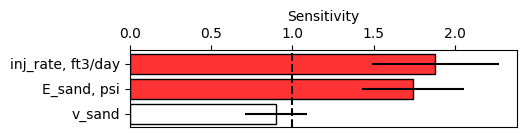

In [33]:
from pyDGSA.plot import vert_pareto_plot

fig, ax = vert_pareto_plot(mean_sensitivity, np_plot='+1', confidence=True)

It's also possible to create a pareto plot of cluster-specific sensitivities, using pre-defined colors for each cluster. Defining the colors is useful for keeping cluster colors consistent across multiple plots

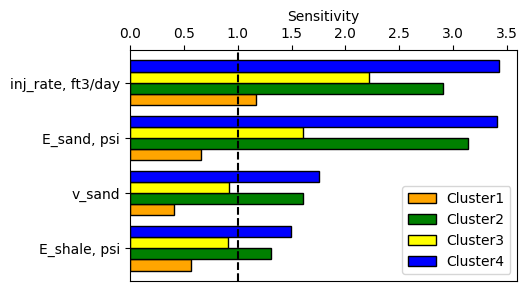

In [35]:
# Define the colors for each cluster
cluster_colors = ['orange', 'green', 'yellow', 'blue']

# Only plot 3 parameters total to save space (np_plot=3)
fig, ax = vert_pareto_plot(cluster_sensitivity, np_plot=4, fmt='cluster_avg', 
                           colors=cluster_colors)

Next, plot the cdf for parameter `z`, using the same color scheme as the pareto plot above.

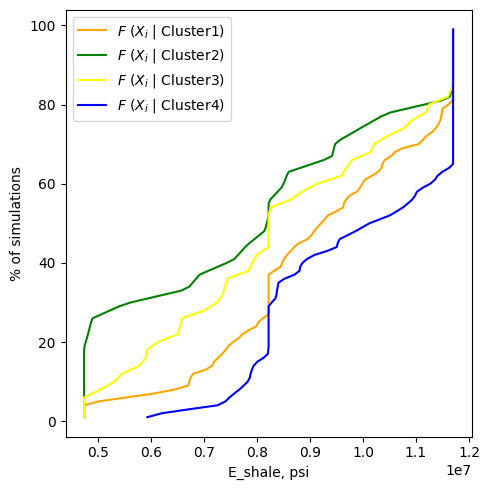

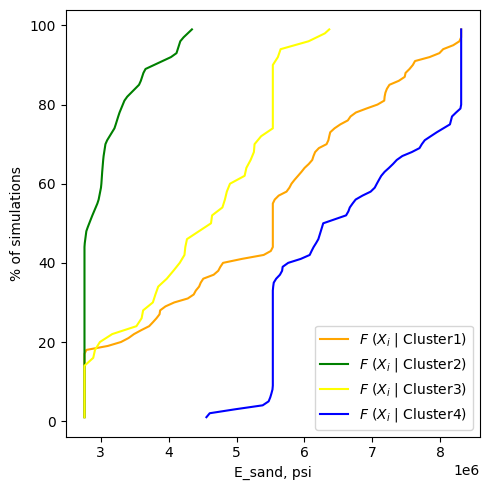

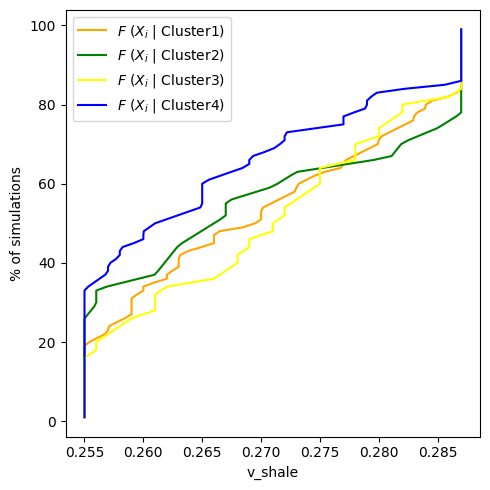

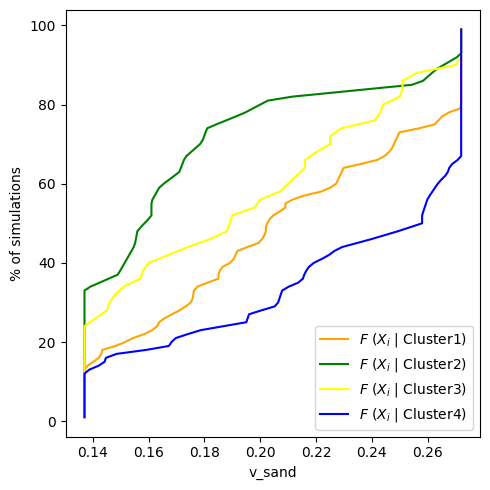

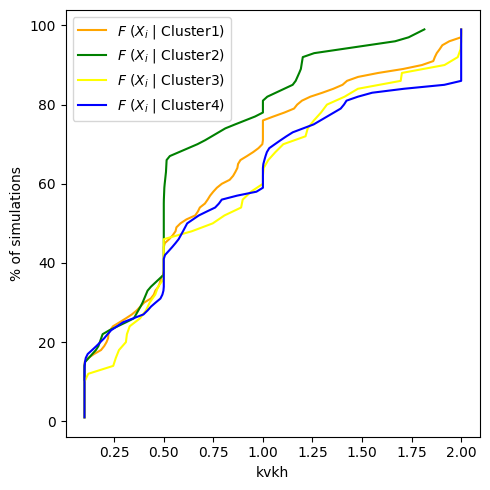

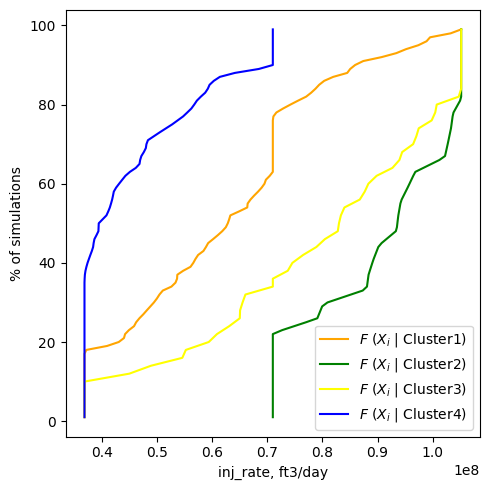

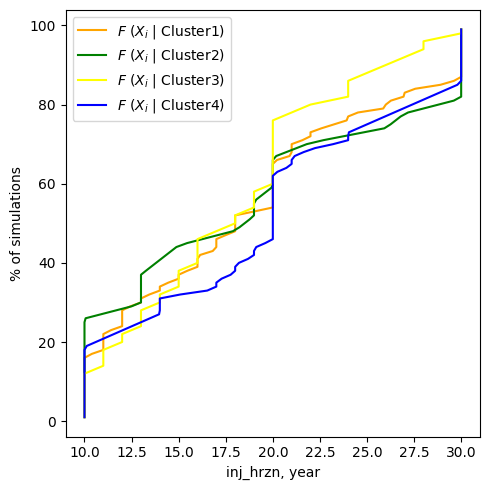

In [36]:
from pyDGSA.plot import plot_cdf

for item in parameter_names:
    fig, ax = plot_cdf(parameters, labels, item, parameter_names=parameter_names, 
                    cluster_names=cluster_names, colors=cluster_colors)

### Plotting response clusters

Next, let's plot the distance between simulations using multidimensional scaling.
This is important, as these distances are the defining feature that control all
other sensitivity calculations.

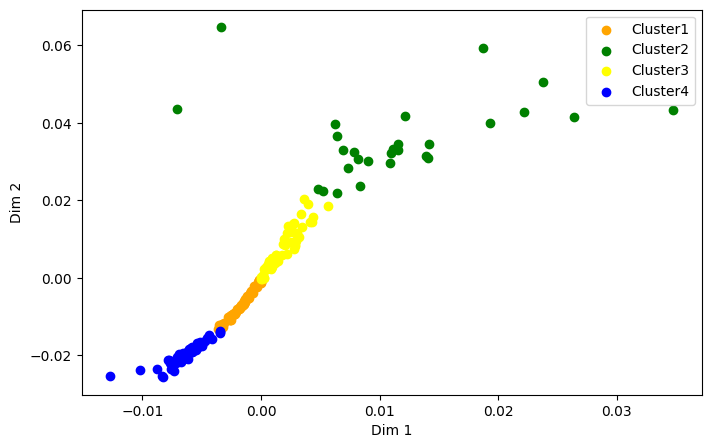

In [37]:
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

# Get MDS representation of distance matrix
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=1, normalized_stress=False)
mds_dist = mds.fit_transform(distances)

## Plot mds distances as scatterplot
fig, ax = plt.subplots(figsize=(8, 5), facecolor='white')
x = mds_dist[:, 0]
y = mds_dist[:, 1]

# Plotting each cluster individually using a for loop,
# though it's possible to plot all clusters at once using
# ax.scatter(x, y, c=[cluster_colors[i] for i in labels])
for i in range(n_clusters):
    sc = ax.scatter(x[labels == i], y[labels == i],
                    c=cluster_colors[i], label=cluster_names[i])
ax.set(xlabel='Dim 1', ylabel='Dim 2')
ax.legend()

### Plotting `dgsa_interactions` results

To display pareto plots of two-way parameter interactions averaged across each cluster and each bin, the options are the same as when plotting `dgsa` results

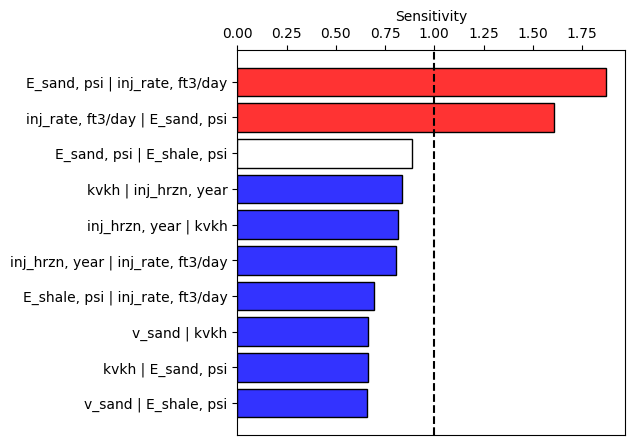

In [38]:
# Only show interactions with sensitivity >= 1 and the next 5 most 
# sensitive interactions (np_plot = '+8')
fig, ax = vert_pareto_plot(mean_interact_sensitivity, np_plot='+8')

Similarly, the options when cluster-specific `dgsa_interactions` results is the same as when plotting cluster-specific `dgsa` results.

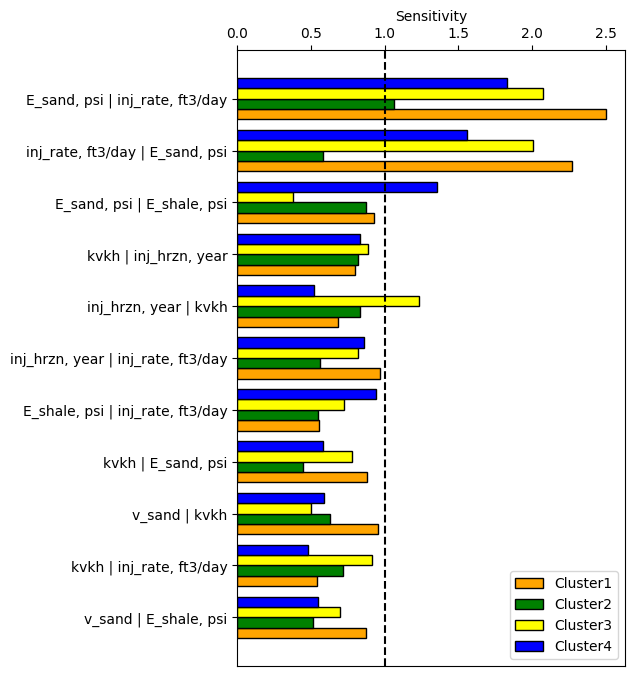

In [39]:
# By default, np_plot = '+5'
fig, ax = vert_pareto_plot(cluster_interact_sensitivity, 
                           fmt='cluster_avg',
                           colors=cluster_colors)

Plot the standardized sensitivity for each bin/cluster combination is also possible. Note that the bars with a bold outline represent those for which the sensitivity >= 1.

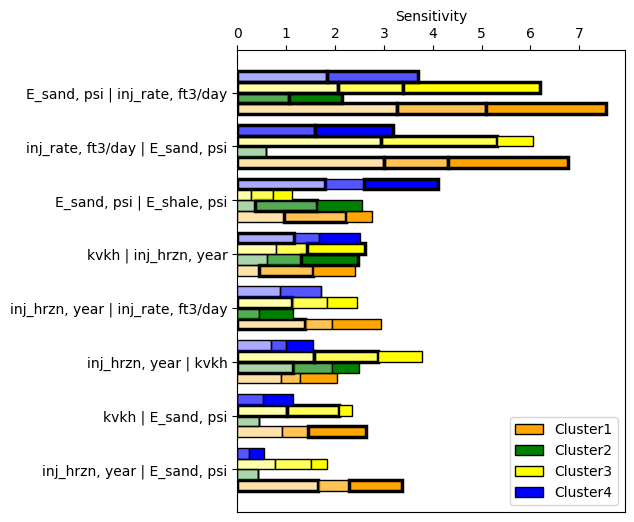

In [40]:
fig, ax = vert_pareto_plot(raw_interact_sensitivity, 
                           fmt='indiv',
                           colors=cluster_colors,
                           np_plot=8)